In [1]:
!nvidia-smi

Failed to initialize NVML: Driver/library version mismatch


In [3]:
import os, glob, time, datetime
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torchvision.utils import save_image

from common.dataset import TrainDataProvider
from common.function import init_embedding
from common.models import Encoder, Decoder, Discriminator, Generator
from common.utils import denorm_image

### GPU Option

In [4]:
GPU = torch.cuda.is_available()
GPU

True

### Path Setting

In [5]:
data_dir = './dataset/'
model_dir = './model_save/'
fixed_dir = './fixed_sample'

### Get Fixed sample

In [6]:
fixed_sources, fixed_targets, fixed_labels = [], [], []

# font별 fixed target
for i in range(25):
    source = torch.load(os.path.join(fixed_dir, 'fixed_source_%d.pkl' % i))
    target = torch.load(os.path.join(fixed_dir, 'fixed_target_%d.pkl' % i))
    label = torch.load(os.path.join(fixed_dir, 'fixed_label_%d.pkl' % i))
    fixed_sources.append(source)
    fixed_targets.append(target)
    fixed_labels.append(label)
    
# 모든 폰트가 섞여있는 target
source = torch.load(os.path.join(fixed_dir, 'fixed_source_all.pkl'))
target = torch.load(os.path.join(fixed_dir, 'fixed_target_all.pkl'))
label = torch.load(os.path.join(fixed_dir, 'fixed_label_all.pkl'))
fixed_sources.append(source)
fixed_targets.append(target)
fixed_labels.append(label)

print("fixed sources:", len(fixed_sources))
print("fixed targets:", len(fixed_targets))
print("fixed labels:", len(fixed_labels))

fixed sources: 26
fixed targets: 26
fixed labels: 26


### fixed_source는 일단 폰트 다 섞여있는 걸로 지정

In [7]:
fixed_source = fixed_sources[-1]
fixed_target = fixed_targets[-1]
fixed_label = fixed_labels[-1]

### Get Fixed Embedding

In [8]:
embeddings = torch.load(os.path.join(fixed_dir, 'EMBEDDINGS.pkl'))
embeddings.shape

torch.Size([100, 1, 1, 128])

### Hyper Parameter Setting

In [9]:
FONTS_NUM = 25
EMBEDDING_NUM = 100
BATCH_SIZE = 32
IMG_SIZE = 128
EMBEDDING_DIM = 128

### Data Provider

In [10]:
data_provider = TrainDataProvider(data_dir)
total_batches = data_provider.compute_total_batch_num(BATCH_SIZE)
print("total batches:", total_batches)

unpickled total 181619 examples
unpickled total 45040 examples
train examples -> 181619, val examples -> 45040
total batches: 5676


In [11]:
def train(max_epoch, schedule, data_dir, save_path, to_model_path, lr=0.001, \
          log_step=100, sample_step=350, fine_tune=False, flip_labels=False, \
          restore=None, from_model_path=False, GPU=True):
    
    # Fine Tuning coefficient
    if not fine_tune:
        L1_penalty, Lconst_penalty = 100, 15
    else:
        L1_penalty, Lconst_penalty = 500, 1000

    # Get Models
    En = Encoder()
    De = Decoder()
    D = Discriminator(category_num=FONTS_NUM)
    if GPU:
        En.cuda()
        De.cuda()
        D.cuda()
    
    # Use pre-trained Model
    # restore에 [encoder_path, decoder_path, discriminator_path] 형태로 인자 넣기
    if restore:
        encoder_path, decoder_path, discriminator_path = restore
        prev_epoch = int(encoder_path.split('-')[0])
        En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
        De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
        D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))
        print("%d epoch trained model has restored" % prev_epoch)
    else:
        prev_epoch = 0
        print("New model training start")

        
    # L1 loss, binary real/fake loss, category loss, constant loss
    if GPU:
        l1_criterion = nn.L1Loss(size_average=True).cuda()
        bce_criterion = nn.BCEWithLogitsLoss(size_average=True).cuda()
        mse_criterion = nn.MSELoss(size_average=True).cuda()
    else:
        l1_criterion = nn.L1Loss(size_average=True)
        bce_criterion = nn.BCEWithLogitsLoss(size_average=True)
        mse_criterion = nn.MSELoss(size_average=True)


    # optimizer
    G_parameters = list(En.parameters()) + list(De.parameters())
    g_optimizer = torch.optim.Adam(G_parameters, betas=(0.5, 0.999))
    d_optimizer = torch.optim.Adam(D.parameters(), betas=(0.5, 0.999))
    
    # losses lists
    l1_losses, const_losses, category_losses, d_losses, g_losses = list(), list(), list(), list(), list()
    
    # training
    count = 0
    for epoch in range(max_epoch):
        if (epoch + 1) % schedule == 0:
            updated_lr = max(lr/2, 0.0002)
            for param_group in d_optimizer.param_groups:
                param_group['lr'] = updated_lr
            for param_group in g_optimizer.param_groups:
                param_group['lr'] = updated_lr
            if lr !=  updated_lr:
                print("decay learning rate from %.5f to %.5f" % (lr, updated_lr))
            lr = updated_lr
            
        train_batch_iter = data_provider.get_train_iter(BATCH_SIZE)   
        for i, batch in enumerate(train_batch_iter):
            labels, batch_images = batch
            embedding_ids = labels
            if GPU:
                batch_images = batch_images.cuda()
            if flip_labels:
                np.random.shuffle(embedding_ids)
                
            # target / source images
            real_target = batch_images[:, 0, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
            real_source = batch_images[:, 1, :, :].view([BATCH_SIZE, 1, IMG_SIZE, IMG_SIZE])
            
            # generate fake image form source image
            fake_target, encoded_source = Generator(real_source, En, De, embeddings, embedding_ids, GPU=GPU)
            
            real_TS = torch.cat([real_source, real_target], dim=1)
            fake_TS = torch.cat([real_source, fake_target], dim=1)
            
            # Scoring with Discriminator
            real_score, real_score_logit, real_cat_logit = D(real_TS)
            fake_score, fake_score_logit, fake_cat_logit = D(fake_TS)
            
            # Get encoded fake image to calculate constant loss
            encoded_fake = En(fake_target)[0]
            const_loss = Lconst_penalty * mse_criterion(encoded_source, encoded_fake)
            
            # category loss
            real_category = torch.from_numpy(np.eye(FONTS_NUM)[embedding_ids]).float()
            if GPU:
                real_category = real_category.cuda()
            real_category_loss = bce_criterion(real_cat_logit, real_category)
            fake_category_loss = bce_criterion(fake_cat_logit, real_category)
            category_loss = 0.5 * (real_category_loss + fake_category_loss)
            
            # labels
            if GPU:
                one_labels = torch.ones([BATCH_SIZE, 1]).cuda()
                zero_labels = torch.zeros([BATCH_SIZE, 1]).cuda()
            else:
                one_labels = torch.ones([BATCH_SIZE, 1])
                zero_labels = torch.zeros([BATCH_SIZE, 1])
            
            # binary loss - T/F
            real_binary_loss = bce_criterion(real_score_logit, one_labels)
            fake_binary_loss = bce_criterion(fake_score_logit, zero_labels)
            binary_loss = real_binary_loss + fake_binary_loss
            
            # L1 loss between real and fake images
            l1_loss = L1_penalty * l1_criterion(real_target, fake_target)
            
            # cheat loss for generator to fool discriminator
            cheat_loss = bce_criterion(fake_score_logit, one_labels)
            
            # g_loss, d_loss
            g_loss = cheat_loss + l1_loss + fake_category_loss + const_loss
            d_loss = binary_loss + category_loss
            
            # train Discriminator
            D.zero_grad()
            d_loss.backward(retain_graph=True)
            d_optimizer.step()
            
            # train Generator
            En.zero_grad()
            De.zero_grad()
            g_loss.backward(retain_graph=True)
            g_optimizer.step()            
            
            # loss data
            l1_losses.append(l1_loss.data)
            const_losses.append(const_loss.data)
            category_losses.append(category_loss.data)
            d_losses.append(d_loss.data)
            g_losses.append(g_loss.data)
            
            # logging
            if (i+1) % log_step == 0:
                time_ = time.time()
                time_stamp = datetime.datetime.fromtimestamp(time_).strftime('%H:%M:%S')
                log_format = 'Epoch [%d/%d], step [%d/%d], l1_loss: %.4f, d_loss: %.4f, g_loss: %.4f' % \
                             (epoch+1, max_epoch, i+1, total_batches, l1_loss.item(), d_loss.item(), g_loss.item())
                print(time_stamp, log_format)
                
            # save image
            if (i+1) % sample_step == 0:
                fixed_fake_images = Generator(fixed_source, En, De, embeddings, fixed_label, GPU=GPU)[0]
                save_image(denorm_image(fixed_fake_images.data), \
                           os.path.join(save_path, 'fake_samples-%d-%d.png' % (epoch+1, i+1)), nrow=8)
        
        if (epoch+1) % 10 == 0:
            now = datetime.datetime.now()
            now_date = now.strftime("%m%d")
            now_time = now.strftime('%H:%M')
            torch.save(En.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Encoder.pkl' \
                                                     % (epoch+1, now_date, now_time)))
            torch.save(De.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Decoder.pkl' % \
                                                     (epoch+1, now_date, now_time)))
            torch.save(D.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Discriminator.pkl' % \
                                                    (epoch+1, now_date, now_time)))

    # save model
    total_epoch = int(prev_epoch) + int(max_epoch)
    end = datetime.datetime.now()
    end_date = end.strftime("%m%d")
    end_time = end.strftime('%H:%M')
    torch.save(En.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Encoder.pkl' % (total_epoch, end_date, end_time)))
    torch.save(De.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Decoder.pkl' % (total_epoch, end_date, end_time)))
    torch.save(D.state_dict(), os.path.join(to_model_path, '%d-%s-%s-Discriminator.pkl' % (total_epoch, end_date, end_time)))
    losses = [l1_losses, const_losses, category_losses, d_losses, g_losses]
    torch.save(losses, os.path.join(to_model_path, '%d-losses.pkl' % max_epoch))

    return l1_losses, const_losses, category_losses, d_losses, g_losses

In [12]:
save_path = './fixed_fake/'
to_model_path = './model_checkpoint/'
losses = train(max_epoch=10, schedule=20, data_dir=data_dir, save_path=save_path, \
               to_model_path=to_model_path, log_step=500, sample_step=300)

New model training start
07:40:02 Epoch [1/10], step [500/5676], l1_loss: 33.4469, d_loss: 0.3163, g_loss: 38.4719
07:42:02 Epoch [1/10], step [1000/5676], l1_loss: 30.2895, d_loss: 0.8853, g_loss: 31.7505
07:44:02 Epoch [1/10], step [1500/5676], l1_loss: 32.2442, d_loss: 2.4007, g_loss: 32.5256
07:46:02 Epoch [1/10], step [2000/5676], l1_loss: 29.0496, d_loss: 0.6326, g_loss: 30.5666
07:48:02 Epoch [1/10], step [2500/5676], l1_loss: 32.1077, d_loss: 0.8825, g_loss: 32.9880
07:50:02 Epoch [1/10], step [3000/5676], l1_loss: 32.0922, d_loss: 0.8688, g_loss: 35.9578
07:52:02 Epoch [1/10], step [3500/5676], l1_loss: 30.4404, d_loss: 0.2471, g_loss: 32.7890
07:54:02 Epoch [1/10], step [4000/5676], l1_loss: 29.8720, d_loss: 0.1466, g_loss: 33.8613
07:56:02 Epoch [1/10], step [4500/5676], l1_loss: 32.4934, d_loss: 0.1129, g_loss: 36.0977
07:58:02 Epoch [1/10], step [5000/5676], l1_loss: 32.9008, d_loss: 0.1822, g_loss: 35.4614
08:00:02 Epoch [1/10], step [5500/5676], l1_loss: 32.0879, d_loss:

10:45:00 Epoch [9/10], step [1500/5676], l1_loss: 30.5700, d_loss: 0.0291, g_loss: 36.4181
10:46:59 Epoch [9/10], step [2000/5676], l1_loss: 33.7535, d_loss: 0.0056, g_loss: 40.8601
10:48:58 Epoch [9/10], step [2500/5676], l1_loss: 30.2137, d_loss: 0.0866, g_loss: 37.2403
10:50:57 Epoch [9/10], step [3000/5676], l1_loss: 29.8458, d_loss: 0.0196, g_loss: 38.4052
10:52:57 Epoch [9/10], step [3500/5676], l1_loss: 28.8220, d_loss: 0.0659, g_loss: 37.0828
10:54:56 Epoch [9/10], step [4000/5676], l1_loss: 32.4022, d_loss: 0.1785, g_loss: 35.8115
10:56:55 Epoch [9/10], step [4500/5676], l1_loss: 31.7428, d_loss: 0.0044, g_loss: 37.9786
10:58:55 Epoch [9/10], step [5000/5676], l1_loss: 32.9723, d_loss: 0.1813, g_loss: 37.6427
11:00:54 Epoch [9/10], step [5500/5676], l1_loss: 30.4845, d_loss: 0.0056, g_loss: 36.7050
11:03:35 Epoch [10/10], step [500/5676], l1_loss: 31.2497, d_loss: 0.0500, g_loss: 35.3283
11:05:35 Epoch [10/10], step [1000/5676], l1_loss: 30.8106, d_loss: 0.0025, g_loss: 37.487

- 약 22분/1epoch : 3시간40분/10epoch



- 1 epoch당 사진 20개 : 300 iter마다 저장

## Losses

In [32]:
l1_losses, const_losses, category_losses, d_losses, g_losses = losses

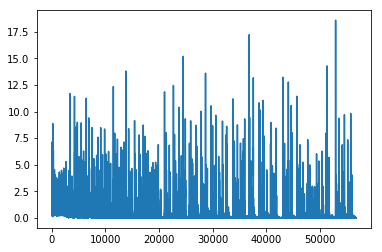

In [33]:
plt.plot(d_losses)
plt.show()

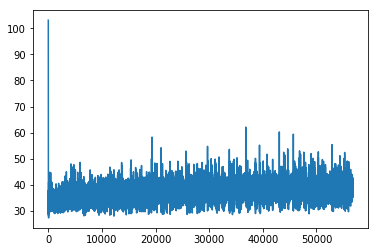

In [34]:
plt.plot(g_losses)
plt.show()

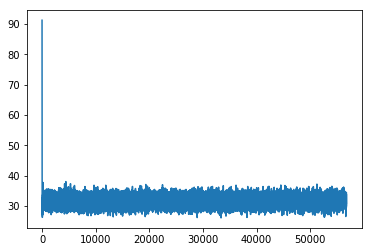

In [35]:
plt.plot(l1_losses)
plt.show()

### 각 폰트마다 상황 보기

In [16]:
En = Encoder().cuda()
De = Decoder().cuda()
D = Discriminator(category_num=FONTS_NUM).cuda()
from_model_path = './model_checkpoint/'
encoder_path = '10-0525-11:24-Encoder.pkl'
decoder_path = '10-0525-11:24-Decoder.pkl'
discriminator_path = '10-0525-11:24-Discriminator.pkl'

En.load_state_dict(torch.load(os.path.join(from_model_path, encoder_path)))
De.load_state_dict(torch.load(os.path.join(from_model_path, decoder_path)))
D.load_state_dict(torch.load(os.path.join(from_model_path, discriminator_path)))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [17]:
fixed_dir = './fixed_sample'

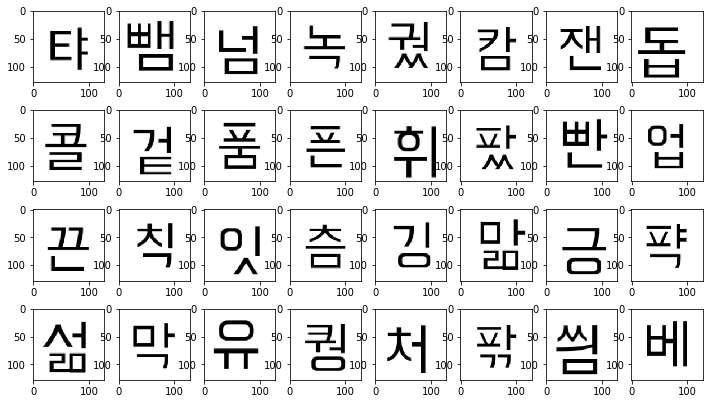

In [19]:
fixed_source_1 = torch.load(os.path.join(fixed_dir, 'fixed_source_1.pkl'))
fixed_fake_images_1 = Generator(fixed_source_1, En, De, embeddings, fixed_label, GPU=GPU)[0]
fixed_target_1 = torch.load(os.path.join(fixed_dir, 'fixed_target_1.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_1):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

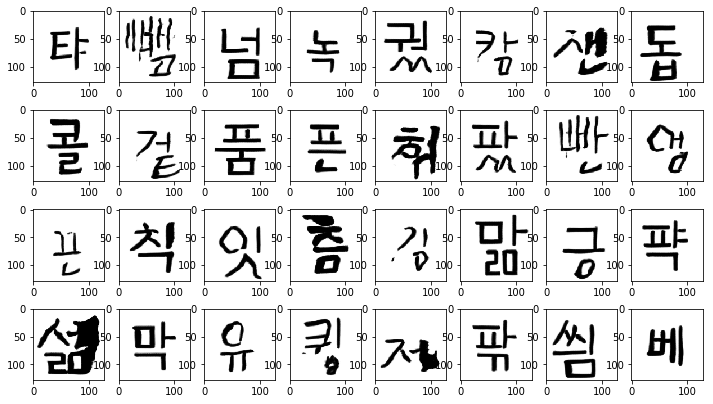

In [21]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_1):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

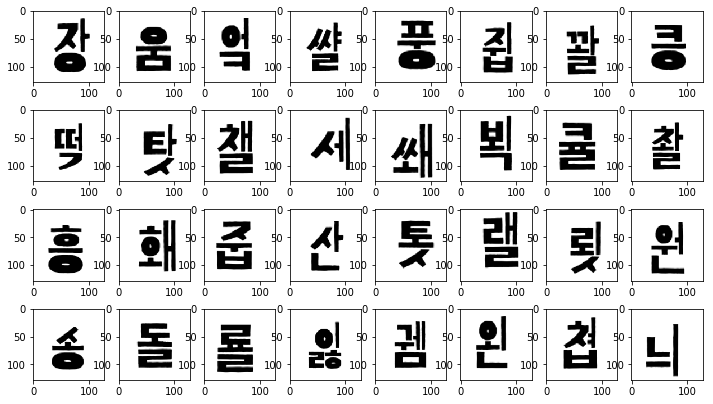

In [22]:
fixed_source_2 = torch.load(os.path.join(fixed_dir, 'fixed_source_2.pkl'))
fixed_fake_images_2 = Generator(fixed_source_2, En, De, embeddings, fixed_label, GPU=GPU)[0]
fixed_target_2 = torch.load(os.path.join(fixed_dir, 'fixed_target_2.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_2):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

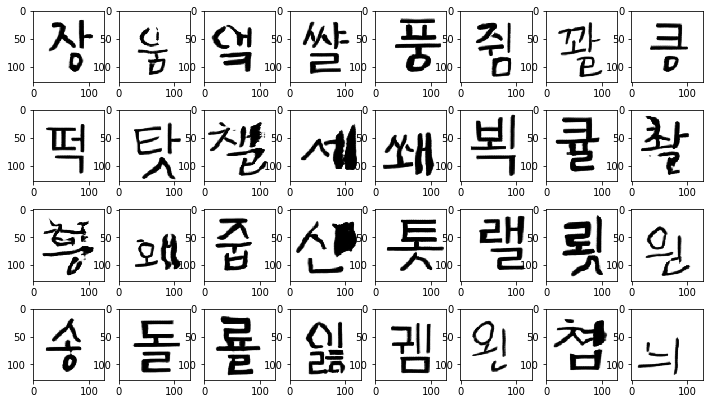

In [23]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_2):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

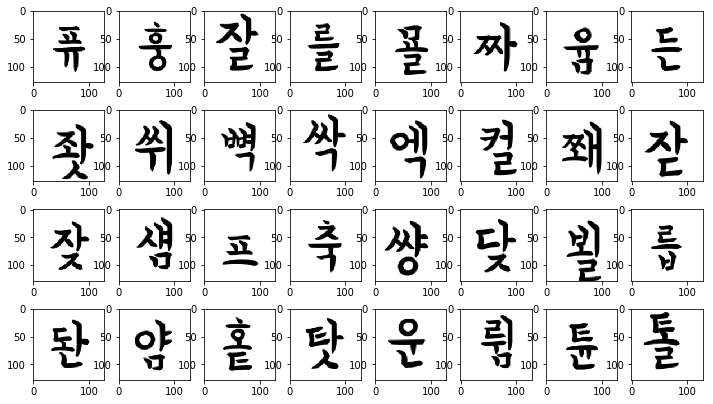

In [24]:
fixed_source_3 = torch.load(os.path.join(fixed_dir, 'fixed_source_3.pkl'))
fixed_fake_images_3 = Generator(fixed_source_3, En, De, embeddings, fixed_label, GPU=GPU)[0]
fixed_target_3 = torch.load(os.path.join(fixed_dir, 'fixed_target_3.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_3):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

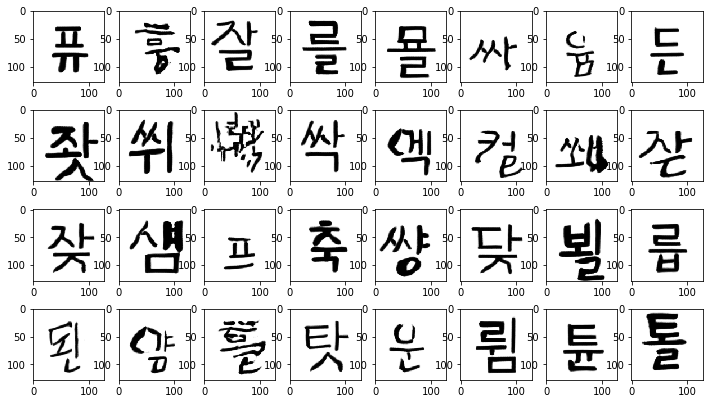

In [25]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_3):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

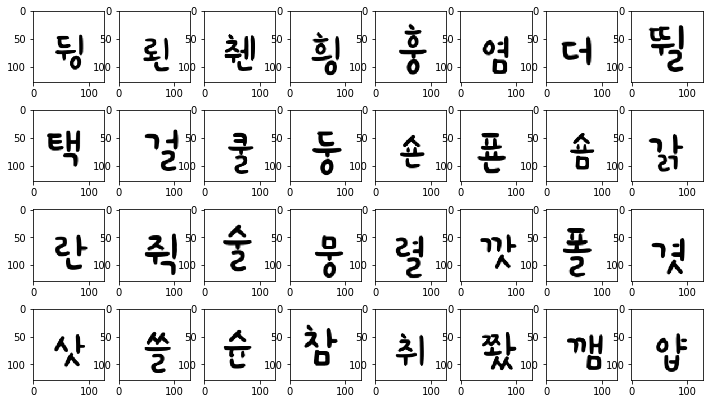

In [27]:
fixed_source_4 = torch.load(os.path.join(fixed_dir, 'fixed_source_4.pkl'))
fixed_fake_images_4 = Generator(fixed_source_4, En, De, embeddings, fixed_label, GPU=GPU)[0]
fixed_target_4 = torch.load(os.path.join(fixed_dir, 'fixed_target_4.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_4):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

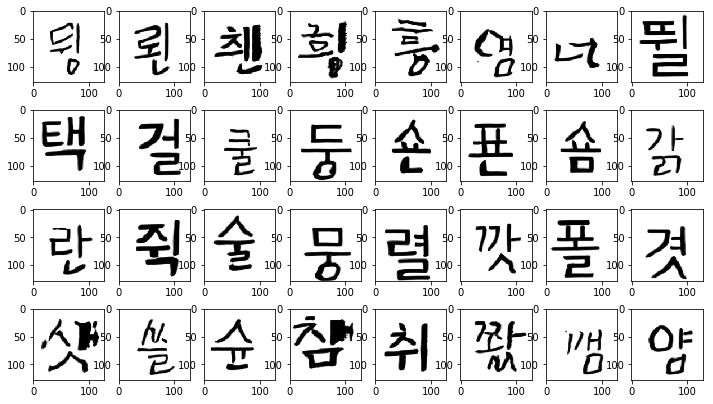

In [28]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_4):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

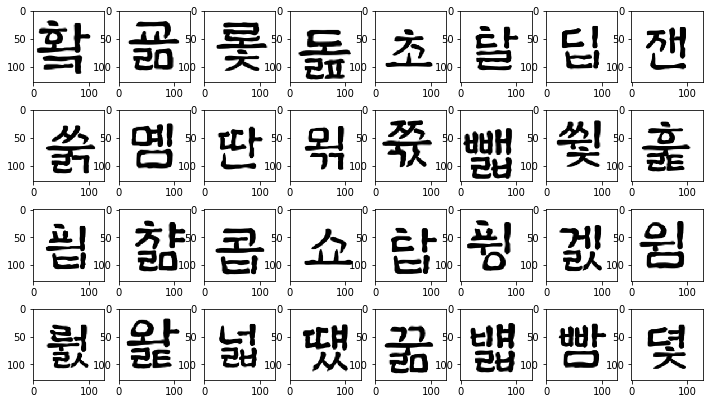

In [29]:
fixed_source_5 = torch.load(os.path.join(fixed_dir, 'fixed_source_5.pkl'))
fixed_fake_images_5 = Generator(fixed_source_5, En, De, embeddings, fixed_label, GPU=GPU)[0]
fixed_target_5 = torch.load(os.path.join(fixed_dir, 'fixed_target_5.pkl'))

plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_target_5):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().numpy(), cmap='gray')
plt.show()

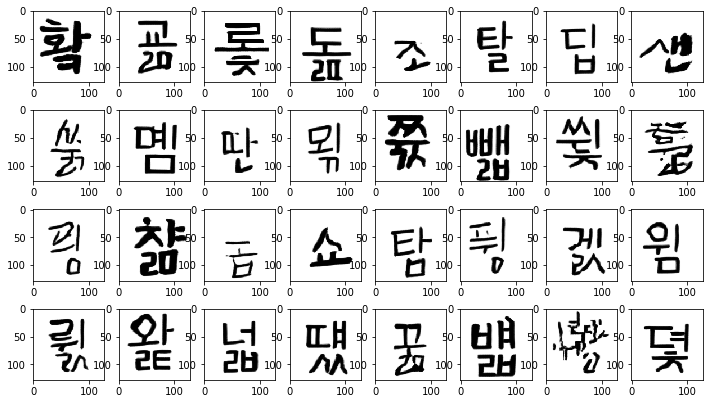

In [30]:
plt.figure(figsize=(12, 7))
for idx, image in enumerate(fixed_fake_images_5):
    plt.subplot(4, 8, idx+1)
    plt.imshow(image.reshape(128, 128).cpu().detach().numpy(), cmap='gray')
plt.show()

처참...ㅎ ㅎ ㅎ 더 돌려보자!